In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

/Users/zhaluza/opt/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST("../Data/", train=True, download=True, transform=transform)


In [4]:
test_data = datasets.MNIST("../Data", train=False, download=True, transform=transform)


In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../Data/
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [7]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

Let's break down our convolutional layers.

We'll eventually incorporate all of this into our model class later, but for now let's examine these details in isolation.

In [8]:
# 1 Color channel (input), 6 filters (output channels), 3x3 kernel, stride=1
conv_layer_1 = nn.Conv2d(1, 6, 3, 1)  # Image --> 6 filters --> pooling --> conv2

# 6 input filters (from layer 1), 16 filter outputs, 3x3 kernel, stride=1
conv_layer_2 = nn.Conv2d(6, 16, 3, 1)


In [9]:
# This loop lets us grab the first batch of data
for i, (X_train, y_train) in enumerate(train_data):
    break

In [10]:
# Default shape: torch.Size([1, 28, 28])
x = X_train.view(1, 1, 28, 28)  # reshape to be a 4D batch (of 1 image)


In [11]:
# Perform first convolution
x = F.relu(conv_layer_1(x))

In [12]:
x.shape
# 1 image, 6 filters, 26 x 26 because we lost some border info during the convolution

torch.Size([1, 6, 26, 26])

In [13]:
# Pass it through a pooling layer
x = F.max_pool2d(x, 2, 2) # kernel size 2x2, stride=2


In [14]:
x.shape

torch.Size([1, 6, 13, 13])

In [15]:
# Pass through our 2nd convolutional layer
x = F.relu(conv_layer_2(x))

In [16]:
x.shape

torch.Size([1, 16, 11, 11])

In [17]:
# Pass it through another pooling layer
x = F.max_pool2d(x, 2, 2)


In [18]:
x.shape

torch.Size([1, 16, 5, 5])

In [19]:
# Then we would feed the output into a flattened layer
x.view(-1, 16 * 5 * 5).shape


torch.Size([1, 400])

Now let's refactor the code above to use a class.

In [20]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution_layer_1 = nn.Conv2d(1, 6, 3, 1)
        self.convolution_layer_2 = nn.Conv2d(6, 16, 3, 1)
        self.fully_connected_layer_1 = nn.Linear(5 * 5 * 16, 120)
        self.fully_connected_layer_2 = nn.Linear(120, 84)
        self.fully_connected_layer_3 = nn.Linear(
            84, 10
        )  # Output must be 10 (we have 10 classes)

    def forward(self, X):
        X = F.relu(self.convolution_layer_1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.convolution_layer_2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 5 * 5)  # Flatten it to feed to to the next layer

        X = F.relu(self.fully_connected_layer_1(X))
        X = F.relu(self.fully_connected_layer_2(X))
        X = self.fully_connected_layer_3(X)
        return F.log_softmax(X, dim=1)


In [21]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (convolution_layer_1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (convolution_layer_2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fully_connected_layer_1): Linear(in_features=400, out_features=120, bias=True)
  (fully_connected_layer_2): Linear(in_features=120, out_features=84, bias=True)
  (fully_connected_layer_3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
for param in model.parameters():
    # print out all the elements in our model parameters
    # This comes out to about half of what our ANN generated
    # And is therefore easier to work with
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [23]:
# Define our loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Time to train our model.

In [24]:
import time
start_time = time.time()

# VARIABLES (TRACKERS)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# FOR LOOP (EPOCHS)
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # TRAIN
    for batch, (X_train, y_train) in enumerate(train_loader):
        batch += 1

        y_pred = model(X_train) # Do not need to flatten - network expects 2D data, unlike ANN
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum() # True 1 / False 0
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print out ome interim resuls
        if batch % 600 == 0:
            print(f"Epoch {i}, Batch {batch}, Loss: {loss.item()}")

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # TEST
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f"Training took {total / 60} minutes")

Epoch 0, Batch 600, Loss: 0.17883241176605225
Epoch 0, Batch 1200, Loss: 0.4943338930606842
Epoch 0, Batch 1800, Loss: 0.03291361406445503
Epoch 0, Batch 2400, Loss: 0.017354849725961685
Epoch 0, Batch 3000, Loss: 0.011598430573940277
Epoch 0, Batch 3600, Loss: 0.009837332181632519
Epoch 0, Batch 4200, Loss: 0.06082184985280037
Epoch 0, Batch 4800, Loss: 0.0009401088464073837
Epoch 0, Batch 5400, Loss: 0.0004627159214578569
Epoch 0, Batch 6000, Loss: 0.004779329523444176
Epoch 1, Batch 600, Loss: 0.05388954281806946
Epoch 1, Batch 1200, Loss: 0.013743053190410137
Epoch 1, Batch 1800, Loss: 0.031119558960199356
Epoch 1, Batch 2400, Loss: 0.01517399400472641
Epoch 1, Batch 3000, Loss: 0.002350729890167713
Epoch 1, Batch 3600, Loss: 0.033778492361307144
Epoch 1, Batch 4200, Loss: 0.8657294511795044
Epoch 1, Batch 4800, Loss: 0.00044227796024642885
Epoch 1, Batch 5400, Loss: 0.0017169509083032608
Epoch 1, Batch 6000, Loss: 0.00604212936013937
Epoch 2, Batch 600, Loss: 0.006275945343077183


Now that we've trained our model, let's visualize the results.

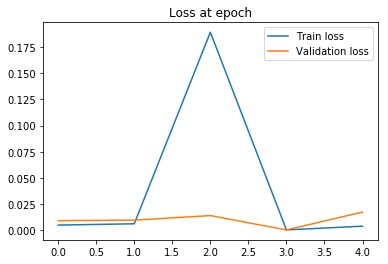

In [25]:
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Loss at epoch")
plt.legend();

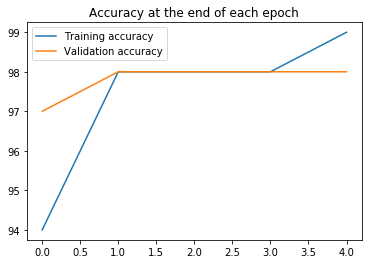

In [26]:
plt.plot([t / 600 for t in train_correct], label="Training accuracy")
plt.plot([t / 100 for t in test_correct], label="Validation accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend();

In [29]:
# Load all the test data (all unseen by the model) and run it through the model
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [30]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [33]:
accuracy = correct.item() / len(test_data)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 98.8%


In [34]:
# Confusion matrix

# Print a row of vals for reference
np.set_printoptions(formatter=dict(int=lambda x: f"{x:4}"))
print(np.arange(10).reshape(1, 10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))


[[   0    1    2    3    4    5    6    7    8    9]]

[[ 973    0    0    0    0    1    5    1    4    0]
 [   0 1127    2    0    0    0    1    3    0    0]
 [   0    1 1024    2    0    0    0    4    3    0]
 [   0    2    1 1005    0    9    0    1    3    3]
 [   0    0    1    0  980    0    4    0    3   11]
 [   0    0    0    2    0  879    3    0    4    7]
 [   3    3    0    0    0    1  943    0    0    0]
 [   1    1    3    0    0    0    0 1015    3    4]
 [   1    1    1    1    0    0    2    1  951    1]
 [   2    0    0    0    2    2    0    3    3  983]]
